### Python and Google spreadsheet connection using APIs
knowledge base courtesy: https://www.analyticsvidhya.com/blog/2020/07/read-and-update-google-spreadsheets-with-python/
##### Created: Yasir khalid, Property: SchoolX, Last-update: 21-Mar-2021
GDPR compliance (personal user data such as Names, Phone numbers and location is hidden)

In [66]:
import requests
import json
import pandas as pd
import config
import datetime

pd.set_option('display.max_columns', None)

#### Ecodings are just something how we store data for classes at our database; these are re-encrypted so our business team can understand the data better
Dates stored in database are in format <'2021-03-21T15:48:42.762Z'> so date cleaning task is also performed using clean_dates() function to extract dates to <21-03-2021> format

In [3]:
encoding = {"5e4a4eb7cfbdec7df147f0e6": "A Level",
            "5e4a4ee8cfbdec7df147f0e7": "O Level",
            "5e55f9ce61482e2a85e7ecb2": "9th",
            "5e55f9d761482e2a85e7ecb3": "10th",
            "5e55f9f361482e2a85e7ecb4": "FSc Part I",
            "5e55f9fa61482e2a85e7ecb5": "FSc Part II"}

In [55]:
def clean_dates(x):
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').strftime("%d-%m-%Y")
    except:
        return x

In [41]:
url = "https://api.schoolx.pk/users/"

payload="{\n}"
headers = {
  'Authorization': config.AUTH,
  'Content-Type': 'application/json'
}
parameters = {"$limit": 0}
response = requests.request("GET", url, headers=headers, data=payload, params=parameters)

# What u get in <response> is a JSON formatted string which u want to convert to python dictionary.
dictionary =  json.loads(response.text)

#### Fetching the data from Postman API (by passing alongside necessary Authentication codes stored in config.py file (not publically released))
Note: API calls limits the return of user entries for you. Since the users stored in database are dynamic (constantly increasing), I have first made the request with a Limit=0, from where I extract the total registrations in the system and then remake the API call with limit set to total registrations in the system (cheeky hack) 

In [56]:
parameters = {"$limit": dictionary["total"]}
response = requests.request("GET", url, headers=headers, data=payload, params=parameters)
dictionary =  json.loads(response.text)
master = pd.DataFrame(dictionary["data"])

In [73]:
temp = master[['_id', 'name', 'createdAt', 'classRoom', 'phone', 'role']]

In [74]:
temp["classRoom"] = temp['classRoom'].map(lambda x: encoding.get(x, x))
temp['createdAt'] = temp['createdAt'].apply(clean_dates)

C:\Users\Yasir Khalid\anaconda3\envs\text-mining\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Yasir Khalid\anaconda3\envs\text-mining\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
temp[['_id', 'classRoom', 'role']].head()

,_id,classRoom,role
0,60576adae9e8507769ecaab6,O Level,student
1,60576abde9e8507769ecaab5,A Level,student
2,60573f79e9e8507769ecaab3,O Level,student
3,6056341de9e8507769ecaaa0,5fc7e9d081d90062ab3d6395,student
4,6055f2a4e9e8507769ecaa9c,O Level,student


### The following code utilises Google spreadsheet/ Google drive API to fetch data from the existing spreadsheet and then store it as pandas dataframe for later comparison

In [62]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [63]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('SchoolX-monitoring-cc64850143a1.json', scope)

# authorize the clientsheet 
client = gspread.authorize(creds)

In [85]:
# get the instance of the Spreadsheet
sheet = client.open('Schoolx Registration Form (Responses)')

# get the first sheet of the Spreadsheet
sheet_instance = sheet.get_worksheet(5)

# sheet_instance.cell(col=1,row=2) -- To fetch a value against a particular row,column from the spreadsheet

#### This lists out all the records which currently exist in the user spreadsheet

In [93]:
records_data = sheet_instance.get_all_records()

In [94]:
records_df = pd.DataFrame.from_dict(records_data)
records_df[["ID", "REGISTERED DATE", "CLASSROOM ID"]].head()

,ID,REGISTERED DATE,CLASSROOM ID
0,,,
1,,,
2,,,
3,,,
4,,,


#### To compare which of user data is missing from operational spreadsheet, against the new data available in our database, we perform a "left-join" which only holds back values which are in our main database and mutually exist in spreadsheets 
Lef-Join is performed on unique user-IDs; and then only values in Left-Table are filtered out
    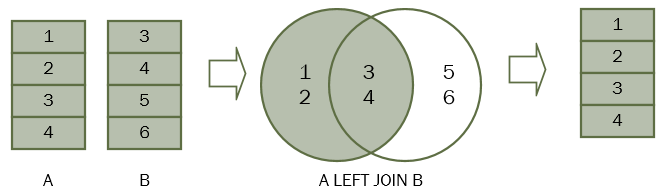

In [95]:
records_df = records_df[["ID"]]
df_all = temp.merge(records_df, left_on='_id', right_on='ID', how='left', indicator=True)
df_all[["_id", "createdAt", '_merge']].head()

,_id,createdAt,_merge
0,60576adae9e8507769ecaab6,21-03-2021,left_only
1,60576abde9e8507769ecaab5,21-03-2021,left_only
2,60573f79e9e8507769ecaab3,21-03-2021,left_only
3,6056341de9e8507769ecaaa0,20-03-2021,left_only
4,6055f2a4e9e8507769ecaa9c,20-03-2021,left_only


In [96]:
newUpdates = df_all[df_all['_merge'] == 'left_only']
newUpdates = newUpdates[["_id", "name", "createdAt", "classRoom", "phone", "role"]]
newUpdates[["_id", "createdAt", "classRoom", "role"]].head()

,_id,createdAt,classRoom,role
0,60576adae9e8507769ecaab6,21-03-2021,O Level,student
1,60576abde9e8507769ecaab5,21-03-2021,A Level,student
2,60573f79e9e8507769ecaab3,21-03-2021,O Level,student
3,6056341de9e8507769ecaaa0,20-03-2021,5fc7e9d081d90062ab3d6395,student
4,6055f2a4e9e8507769ecaa9c,20-03-2021,O Level,student


### Pushing new data back to spreadsheet

In [97]:
temp_push = newUpdates.values.tolist()

In [98]:
sheet_instance.insert_rows(row = 2, values = temp_push)

{'spreadsheetId': '1muHApHGELHqIwoHL2eMB_YEzGdNDzUYxkdD5I6WZrFU',
 'updates': {'spreadsheetId': '1muHApHGELHqIwoHL2eMB_YEzGdNDzUYxkdD5I6WZrFU',
  'updatedRange': 'Automation!A2:F1567',
  'updatedRows': 1566,
  'updatedColumns': 6,
  'updatedCells': 9396}}

## Extra (Appendix): supporting codes

In [ ]:
dw = pd.DataFrame(columns=['id', 'Name','Register_date', 'section', 'number', 'category', 'country', 'city'])

for i in dictionary["data"]:
    try:
        dw = dw.append({'id': i["_id"], 'Name': i["name"], 'section': i['classRoom'], 'number': i['phone'], 'category': i["role"], 'Register_date': i["createdAt"], 'country': i["country"], 'city': i["city"]}, ignore_index=True)
    except:
        dw = dw.append({'id': i["_id"], 'section': i['classRoom'], 'number': i['phone'], 'Name': i["name"], 'category': i["role"], 'Register_date': i["createdAt"], 'country': i["country"], 'city': np.nan}, ignore_index=True)